In [1]:
import pandas as pd
import csv
import pymongo
from pymongo import InsertOne,DeleteOne,UpdateOne
import matplotlib.pyplot as plt

In [2]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None,db='test'):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()

In [3]:
# 存第一个issue
collection = client.gfibot.dataset

db = collection.find({"resolver_commit_num":0})
collection1 = client.issues.first_issues
res = collection1.delete_many({})
res = collection1.insert_many(db,ordered=False)

In [4]:
# 去除issue刚建立的时候的数据(gfi-bot数据集一个issue有两条数据)
delete_lst = []
for data in collection1.find():
    if data["created_at"] == data["before"]:
        delete_lst.append(DeleteOne(data))
res = collection1.bulk_write(delete_lst)

In [5]:
tmp_collection = client.gfibot.resolved_issue

# 将resolved_issue中多的feature导入first_issues中
update_lst = []
for data in collection1.find():
    res = tmp_collection.find_one({"owner":data["owner"],"name":data["name"],"number":data["number"]})
    update_lst.append(UpdateOne({"_id":data["_id"]},{"$set":{"resolver":res["resolver"],"resolved_in":res["resolved_in"]}}))
# 更新数据集
res = collection1.bulk_write(update_lst)

In [6]:
collection1 = client.issues.first_issues
db = collection1.find()
collection2 = client.issues.first_issues1 # 备份
res = collection2.delete_many({})
res = collection2.insert_many(db,ordered=False)

In [7]:
inr = []  # 前两个issue的时间间隔
delete_lst = []
for data in collection1.find():
    # 取resolver_commit_num>=1且解决时间最早的一条数据作为第二个issue
    res = tmp_collection.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"],"resolver_commit_num":{"$gte":1}}).sort([("resolved_at",1)]).skip(0).limit(1)
    for item in res:
        t = (item["resolved_at"]-data["closed_at"]).days
        if t >= 0:
            inr.append(t)
        else:
            delete_lst.append(DeleteOne(data))
print(len(inr),len(delete_lst))

# 去除resolver_commit_num>=1时间比resolver_commit_num=0更早的数据
res = collection1.bulk_write(delete_lst) # 去除了127/16692 = 0.76%的数据

4074 127


                 0
count  4074.000000
mean    151.253314
std     283.221133
min       0.000000
25%       6.000000
50%      27.000000
75%     160.000000
max    3390.000000
469


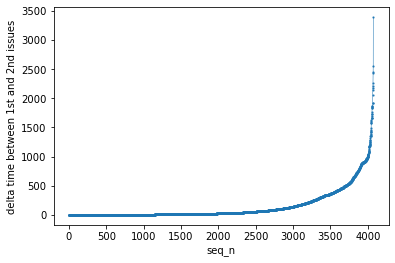

In [8]:
inr = sorted(inr)

fig, ax = plt.subplots()
plt.xlabel("seq_n")
plt.ylabel("delta time between 1st and 2nd issues")
ax.plot(range(len(inr)), inr, '-s', linewidth=0.5, markersize=1)

print(pd.DataFrame(inr).describe())

dt = inr[int(len(inr)*0.9)-1]
print(dt) # 90%值

In [9]:
# 去除无法判别为otc或notc的issue    
delete_lst = []
for data in collection1.find():
    if (pd.to_datetime("2022-07-01 00:00:00") - data["closed_at"]).days < dt and tmp_collection.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}).count() <= 1:
        delete_lst.append(DeleteOne(data))
        
res = collection1.bulk_write(delete_lst)
print(len(delete_lst)) 
# 去除了1624/16692 = 9.73% 的数据

<ipython-input-9-6c1c59d3bbed>:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if (pd.to_datetime("2022-07-01 00:00:00") - data["closed_at"]).days < dt and tmp_collection.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}).count() <= 1:


1624


In [10]:
inr2 = []  # notc的第一个和最后一个issue的时间间隔
for data in collection1.find():
    # 取resolver_commit_num>=1且解决时间最晚的一条数据作为最后一个issue
    res = tmp_collection.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"],"resolver_commit_num":{"$gte":1}}).sort([("resolved_at",-1)]).skip(0).limit(1)
    for item in res:
        t = (item["resolved_at"]-data["closed_at"]).days
        inr2.append(t)

                 0
count  4074.000000
mean    402.251595
std     545.004560
min       0.000000
25%      27.000000
50%     167.000000
75%     564.500000
max    3390.000000


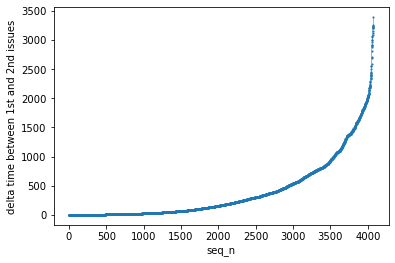

In [11]:
inr2 = sorted(inr2)

fig, ax = plt.subplots()
plt.xlabel("seq_n")
plt.ylabel("delta time between 1st and 2nd issues")
ax.plot(range(len(inr2)), inr2, '-s', linewidth=0.5, markersize=1)

print(pd.DataFrame(inr2).describe())

In [14]:
print(inr2[int(len(inr2)*0.10)-1]) # 10%值
print(inr2.index(1)/len(inr2)) # <1天占比
print(inr2.index(2)/len(inr2)) # <=1天占比
print(inr2.index(4)/len(inr2)) # <=3天占比
print(inr2.index(8)/len(inr2)) # <=7天占比
dt = inr2.index(4)/len(inr2)

6
0.006381934216985763
0.031418753068237604
0.06578301423662249
0.12002945508100148
